In [ ]:
## remove output before conversion to .py

In [1]:
import xarray as xr
from datacube.helpers import write_geotiff
import datacube
from datetime import date,datetime,timedelta
from dateutil.relativedelta import relativedelta
from dask.distributed import Client
import matplotlib.pyplot as plt
%matplotlib widget
import sys
import os
sys.path.append('src')
from anomalies import load_landsat, display_map, map_shapefile

In [2]:
#delete old client if one still exists
client = locals().get('client', None)
if client is not None:
    client.close()
    del client
    
client = Client(n_workers=3, threads_per_worker=1, memory_limit='9GB')
client

Client Scheduler: tcp://127.0.0.1:42359 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 3 Cores: 3 Memory: 27.00 GB


In [15]:
#input parameters
veg_index='ndvi'
from_shape = False
shp_fpath = "_"
chunk_size = 750
latitude_range = ( -33.5, -33)
longitude_range = (146.5, 150)
#nsw bounding box
# latitude_range = (-37.53, -28.15)
# longitude_range = (140.99, 153.66)


In [16]:
# If your specifying a lat, lon and buffer, run this cell
display_map(y=(latitude_range), x=(longitude_range))

In [17]:
# Generate 3-month time frame relative to today.
lastday=date.today().replace(day=1)-timedelta(1)

firstday=lastday + relativedelta(months=-2)
firstday=firstday.replace(day=1)  # Use last 3 months starting from firt of month
firstday,lastday

time=(firstday.strftime('%Y-%m'),lastday.strftime('%Y-%m'))
time

('2019-10', '2019-12')

In [18]:
#  use for reading in relevant climatology files
firstmonth=firstday.month

quarter_dict= {1:'JFM',
               2:'FMA',
               3:'MAM',
               4:'AMJ',
               5:'MJJ',
               6:'JJA',
               7:'JAS',
               8:'ASO',
               9:'SON',
               10:'OND',
               11:'NDJ',
               12:'DJF',
              }
season=quarter_dict[firstmonth]
year=str(firstday.year)
year,season # for writing file

('2019', 'OND')

In [19]:
def calculate_anomalies(veg_index, from_shape, shp_fpath,
                        time, season, latitude_range, longitude_range,chunk_size):
    
    #error messaging for important inputs
    if veg_index not in ('msavi', 'ndvi'):
        raise ValueError("Veg_index must be either 'msavi' or 'ndvi'")
    

    if from_shape:
        if len(fiona.open(shp_fpath)) > 1:
            warnings.warn("This script can only accept shapefiles with a single polygon feature; "
                          "seasonal anomalies will be calculated for the extent of the "
                          "first geometry in the shapefile only.")
        
    #connect to datacube
    dc = datacube.Datacube(app='load_clearlandsat')
    
    #get data from shapefile extent and mask
    if from_shape:
        print("extracting data based on shapefile extent")
        
        with fiona.open(shp_fpath) as input:
            crs = geometry.CRS(input.crs_wkt)
        
        feat = fiona.open(shp_fpath)[0]
        first_geom = feat['geometry']
        geom = geometry.Geometry(first_geom, crs=crs)

        query = {'geopolygon': geom,
                 'time': time}
        
        ds = load_landsat(dc=dc, query=query, sensors=['ls5','ls7','ls8'], 
                           bands_of_interest=['nir', 'red'], lazy_load=True,
                           dask_chunks = {'x': chunk_size, 'y': chunk_size})
        
        mask = rasterio.features.geometry_mask([geom.to_crs(ds.geobox.crs)for geoms in [geom]],
                                       out_shape=ds.geobox.shape,
                                       transform=ds.geobox.affine,
                                       all_touched=False,
                                       invert=False)
        
        mask_xr = xr.DataArray(mask, dims = ('y','x'))
        ds = ds.where(mask_xr==False)
        
    else: 
        print('Extracting data based on lat, lon coords')
        # todo - change to bounding box
        query = {'lon': longitude_range,
                 'lat': latitude_range,
                 'time': time}
        
        ds = load_landsat(dc=dc, query=query, sensors=['ls5','ls7','ls8'], 
                           bands_of_interest=['nir', 'red'], lazy_load=True,
                           dask_chunks = {'x': chunk_size, 'y': chunk_size})

    
    print('calculating vegetation indice')
    
    if veg_index == 'ndvi':
        vegIndex = (ds.nir - ds.red) / (ds.nir + ds.red)
        vegIndex = vegIndex.astype('float32')
        vegIndex = vegIndex.mean('time').rename(veg_index+'_mean')
        
    #get the bounding coords of the input ds to help with indexing the climatology
    xmin, xmax = vegIndex.x.values[0], vegIndex.x.values[-1]
    ymin,ymax = vegIndex.y.values[0], vegIndex.y.values[-1]
    x_slice = [i+0.5 for i in range(int(xmin),int(xmax+25),25)]
    y_slice = [i-0.5 for i in range(int(ymin),int(ymax-25),-25)]
    
    return vegIndex

## uncomment after climatologies generated
    
#     #index the climatology dataset to the location of our AOI
#     #fixme - what are the filenames going to be?
#     print('Opening mean climatology for: NSW ' + veg_index +' '+ season)
#     mean_climatology = xr.open_rasterio('results/NSW_' + veg_index + "_clim_mean_"+ season +'_mosaic.tif',
#                                   chunks=chunk_size).sel(x=x_slice, y=y_slice, method='nearest').squeeze()
#     print('Opening standard deviation climatology for: NSW ' + veg_index +' '+ season)
#     stdev_climatology = xr.open_rasterio('results/NSW_' + veg_index + "_clim_stdev_"+ season +'_mosaic.tif',
#                                   chunks=chunk_size).sel(x=x_slice, y=y_slice, method='nearest')
    
#     #test if the arrays match before we calculate the anomalies
#     np.testing.assert_allclose(vegIndex.x.values, climatology.x.values,
#                               err_msg="The X coordinates on the AOI dataset do not match "
#                                       "the X coordinates on the climatology dataset. "
#                                        "You're AOI may be beyond the extent of the pre-computed "
#                                        "climatology dataset.")
    
#     np.testing.assert_allclose(vegIndex.y.values, climatology.y.values,
#                           err_msg="The Y coordinates on the AOI dataset do not match "
#                                   "the Y coordinates on the climatology dataset. "
#                                    "You're AOI may be beyond the extent of the pre-computed "
#                                    "climatology dataset.")
    
#     print('calculating anomalies')
#     #calculate anomalies
#     anomalies = (vegIndex - mean_climatology)/stdev_climatology

    
#     #add back metadata
#     anomalies = anomalies.rename(veg_index + '_anomalies').to_dataset()
#     anomalies.attrs = ds.attrs
#     anomalies.attrs['units'] = 1

#     return anomalies


In [20]:
#Lazily run calculations, this will check for errors before
# we actually compute the results
std_anomalies = calculate_anomalies(veg_index=veg_index, #ndvi     
                                from_shape=from_shape,
                                shp_fpath=shp_fpath,
                                latitude_range=latitude_range, #AOI NSW - use bounding box in future
                                longitude_range=longitude_range, #AOI NSW - use bounding box in future                             
                            time=time, # time of extraction (last 3 months)
                            season=season, # clim season based on extraction (move into func?)
                            chunk_size=chunk_size)
std_anomalies = std_anomalies.rename(veg_index + '_anomalies').to_dataset()

print(std_anomalies)

Extracting data based on lat, lon coords
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Skipping ls7; no valid data for query
Loading ls8
calculating vegetation indice
<xarray.Dataset>
Dimensions:         (x: 13137, y: 3860)
Coordinates:
  * y               (y) float64 -3.675e+06 -3.675e+06 ... -3.772e+06 -3.772e+06
  * x               (x) float64 1.336e+06 1.336e+06 ... 1.664e+06 1.664e+06
Data variables:
    ndvi_anomalies  (y, x) float32 dask.array<chunksize=(750, 750), meta=np.ndarray>


In [21]:
%%time
std_anomalies=std_anomalies.compute()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 1min 32s, sys: 1min 20s, total: 2min 53s
Wall time: 1min 42s


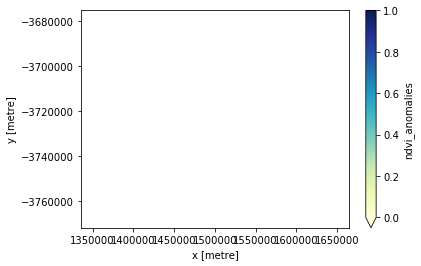

In [23]:
## don't do if too large
#currently is only compositve NDVI (not anomaly)
std_anomalies.ndvi_anomalies.plot(vmin=0, vmax=1, cmap='YlGnBu')

plt.title(season+ ", " +str(year))
# plt.show()

In [25]:
# Write geotiff to a location
year=str(firstday.year)
print('NSW_'+year+'_'+season+'_'+veg_index+ '_anomalies.tif')
write_geotiff(veg_index+"_"+year+"_"+season+ '_anomalies.tif', std_anomalies)

NSW_2019_OND_ndvi_anomalies.tif


ValueError: Can only write datasets with specified `crs` attribute